<h1><center>
    Implementing, and using GNN architectures. <br/>
  
    
    Project 3
</center></h1>

# Theory Question 1
<img src="https://i.stack.imgur.com/HIV6k.png" width="300">

Given the graph above with and without coloring, describe which machine learning algorithms preserve the topological information irrespective of the geometric visualization. Here and in the following different colored edges represent different edge relations. Please consider the graph that is visualized and not the picture of the graph.


First we can consider the graph witout colour. This is a fully connected graph, where each node is connected by an edge. In other words, every vertex in a fully connected graph is directly connected to every other vertex. Since there is no specific ordering, there are no permutations to consider. Therefore we can use a variety of machine learning approaches that work well for fully connected graphs where permutations are not an issue such as Graph Neural Networks (GNNs) and Deep Sets.  <br>

Considering only the red or only the blue edges, not all nodes in the network are connected. Here there are other Networks that can be used, as permutational invariance is essential. Specifically Graph Convolutional Networks (GCNs) and Graph Attention Networks (GATs) are capable of working with non-fully connected graphs as they contain some permutation invariance. Graph Attention Networks combine elements of Transformers into their architecture to better process topological information with attention. A readout mechanism is used to generate a fixed-length representation of the entire graph (embedding) and in combination with the attention, permutation invariance can be achieved. 

# Task 1.1
Given the graph visualized in Theory Question 1. Visualize the graph in a datastructure of your choice, if your result does not match the geometry in the figure construct an isomorphism between the two graphs.

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
red_graph = np.array([[0, 1, 0, 0, 1],
                    [1, 0, 1, 0, 0],
                    [0, 1, 0, 1, 0],
                    [0, 0, 1, 0, 1],
                    [1, 0, 0, 1, 0]])

blue_graph = np.array([[0, 0, 1, 1, 0],
                    [0, 0, 0, 1, 1],
                    [1, 0, 0, 0, 1],
                    [1, 1, 0, 0, 0],
                    [0, 1, 1, 0, 0]])

no_colour_graph = blue_graph + red_graph


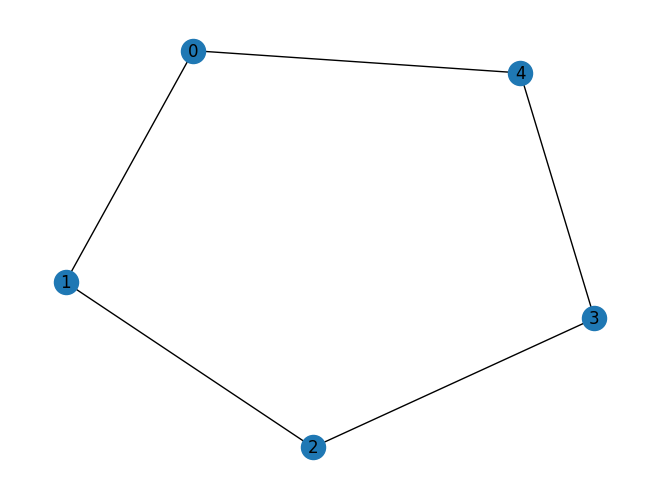

In [3]:

G = nx.Graph(red_graph)
nx.draw(G, with_labels=True)
plt.show()

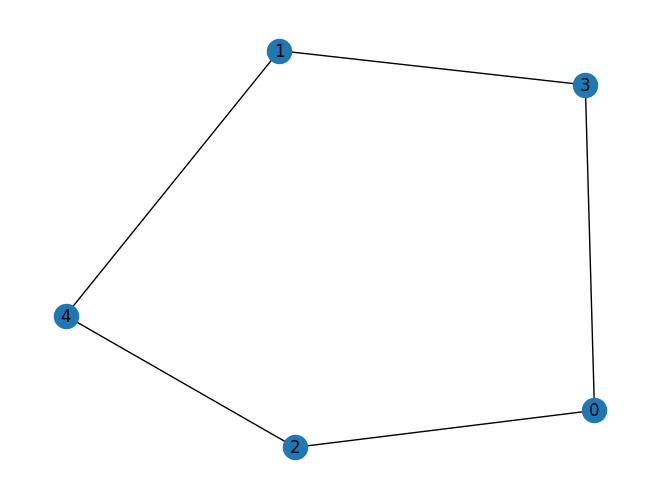

In [4]:
G = nx.Graph(blue_graph)
nx.draw(G, with_labels=True)
plt.show()

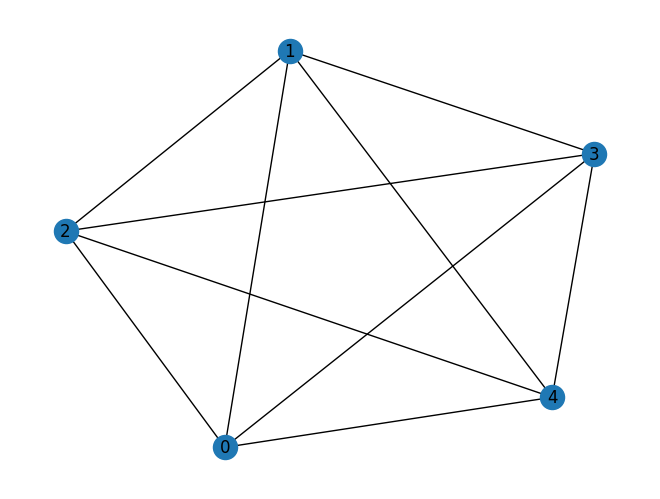

In [5]:
G = nx.Graph(no_colour_graph)
nx.draw(G, with_labels=True)
plt.show()

# Task 1.2
Given the graph shown in the image of theory question 1. Implement from scratch using <b>only numpy</b> both graph convolutions when respecting the coloring and without respecting the coloring (edge relation).

# Task 1.2.1
Graph Convolution without edge coloring.

In [6]:
# Define the feature matrix
# we only have 1 feature per node and all are 1
feature_matrix = np.array([[1], [1], [1], [1], [1]])

# Initialize the weight matrices using xaiver initialization
W1 = np.array([np.random.normal(0, 1/ len(feature_matrix))])
W2 = np.array([np.random.normal(0, 1/ len(feature_matrix))])
W3 = np.array([np.random.normal(0, 1/ len(feature_matrix))])
W4 = np.array([np.random.normal(0, 1/ len(feature_matrix))])
W5 = np.array([np.random.normal(0, 1/ len(feature_matrix))])

# Compute the output feature matrix
Z1 = np.dot(no_colour_graph, np.dot(feature_matrix, W1))
Z2 = np.dot(no_colour_graph, np.dot(feature_matrix, W2))
Z3 = np.dot(no_colour_graph, np.dot(feature_matrix, W3))
Z4 = np.dot(no_colour_graph, np.dot(feature_matrix, W4))
Z = Z1 + Z2 + Z3 + Z4
# sigma activation function
output = 1 / (1 + np.exp(-Z))
output


array([0.39413096, 0.39413096, 0.39413096, 0.39413096, 0.39413096])

# Task 1.2.2
Graph Convolution with edge coloring.

In [7]:
red_blue_graph = np.stack((red_graph, blue_graph))
red_blue_graph.shape

(2, 5, 5)

In [8]:
# Define the feature matrix
# we only have 1 feature per node and all are 1
feature_matrix = np.array([[1], [1], [1], [1], [1]])

# Initialize the weight matrices using xaiver initialization
W1 = np.array([np.random.normal(0, 1/ len(feature_matrix))])
W2 = np.array([np.random.normal(0, 1/ len(feature_matrix))])
W3 = np.array([np.random.normal(0, 1/ len(feature_matrix))])
W4 = np.array([np.random.normal(0, 1/ len(feature_matrix))])
W5 = np.array([np.random.normal(0, 1/ len(feature_matrix))])

# Compute the output feature matrix
Z1 = np.dot(red_blue_graph, np.dot(feature_matrix, W1))
Z2 = np.dot(red_blue_graph, np.dot(feature_matrix, W2))
Z3 = np.dot(red_blue_graph, np.dot(feature_matrix, W3))
Z4 = np.dot(red_blue_graph, np.dot(feature_matrix, W4))
Z = Z1 + Z2 + Z3 + Z4
# sigma activation function
output = 1 / (1 + np.exp(-Z))
output

array([[0.46771546, 0.46771546, 0.46771546, 0.46771546, 0.46771546],
       [0.46771546, 0.46771546, 0.46771546, 0.46771546, 0.46771546]])

# Task 2

We will now reinterpret the exercise that we had in the last assignment.

In the following, we want to train a GNN using the [Deep Graph Library (DGL)](https://github.com/dmlc/dgl) using the data set from last week  ([Tensorflow version](https://www.tensorflow.org/datasets/catalog/yelp_polarity_reviews) and [(py)torch version](https://pytorch.org/text/stable/datasets.html#yelpreviewpolarity).

Recap:
Given the text of a review, we want to determine whether the yelp review is positive and negative. The data set is pre-split into training and test set. Please use the training data to fine-tune your model, while using the test data to evaluate your models performance. This exercise does not necessarily end in having a SOTA model, the goal is for you to use and fine-tune SOTA pretrained large language models.

Problem Setting:

The label $y$ to a Yelp review $T$ is either positive or negative. Given a Yelp Review $T$ and a polarity feedback $y$ determine whether the Review $T$ is positive or negative. The training set $\mathcal{D} = \{(T_1, y_1), \ldots, (T_N, y_N)\}$, where $T_i$ is review $i$ and $y_i$ is $T_i$'s polarity feedback. Use <b>AUC</b> as Evaluation Metric.

In the following, please solve all subtasks as well as the .

## Task 2.0
Load the Yelp Review Polarity dataset. Here it is also possible to only use part of the data (e.g. 5%)

In [1]:
from torchtext.datasets import YelpReviewPolarity
import torch

# Load YelpReviewPolarity dataset, split into train and test
# datatype: ShardingFilterIterDataPipe
train_data, test_data = YelpReviewPolarity(root='.data', split=('train', 'test'))

percentage_to_use = 0.000005 #change nr if you want more/less train data

train_split_index = int(len(list(train_data)) * percentage_to_use)
test_split_index = int(len(list(test_data)) * percentage_to_use)

## Task 2.1
Reinterpret the text data as graph data using DGL.

In [2]:
import dgl
from transformers import BertModel, BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

train_graphs = []
train_split_index = max(train_split_index, 100)
train_data = list(train_data)[:train_split_index] 

for i in range(len(train_data)):
    if i % 100 == 0:
        print('Train progess: ', i, ' of ', len(train_data))
    # split train data instance into label and text inputs
    label, inputs = train_data[i]

    # tokenize text
    tokenized_inputs = tokenizer(inputs, padding=True, add_special_tokens=True,  truncation=True, return_tensors="pt")

    # get embeddings for tokens
    mask = tokenized_inputs['attention_mask']
    input_id = tokenized_inputs['input_ids']
    output = model(input_id, mask)

    # initialize graph with nodes
    g = dgl.DGLGraph()
    g.add_nodes(len(output['last_hidden_state'][0]), {'lhs': output['last_hidden_state'][0]})

    # get lists of edge sources and destinations (every token has a directed edge to the succeding token)
    edge_src = list(range(0, len(output['last_hidden_state'][0])))
    edge_dst = list(range(1, len(output['last_hidden_state'][0]) + 1))

    # add the edges
    g.add_edges(edge_src, edge_dst)

    # add self-loop to avoid having 0 in-degree nodes
    g = dgl.add_self_loop(g)
    
    # append graph of this review to list
    train_graphs.append((g, label))


test_graphs = []
test_split_index = max(test_split_index, 50)
test_data = list(test_data)[:test_split_index] 

for i in range(len(test_data)):
    if i % 100 == 0:
        print('Test progess: ', i, ' of ', len(test_data))
    # split test data instance into label and text inputs
    label, inputs = test_data[i]

    # tokenize text
    tokenized_inputs = tokenizer(inputs, padding=True, add_special_tokens=True,  truncation=True, return_tensors="pt")

    # get embeddings for tokens
    mask = tokenized_inputs['attention_mask']
    input_id = tokenized_inputs['input_ids']
    output = model(input_id, mask)

    # initialize graph with nodes
    g = dgl.DGLGraph()
    g.add_nodes(len(output['last_hidden_state'][0]), {'lhs': output['last_hidden_state'][0]})

    # get lists of edge sources and destinations (every token has a directed edge to the succeding token)
    edge_src = list(range(0, len(output['last_hidden_state'][0])))
    edge_dst = list(range(1, len(output['last_hidden_state'][0]) + 1))

    # add the edges
    g.add_edges(edge_src, edge_dst)

    # add self-loop to avoid having 0 in-degree nodes
    g = dgl.add_self_loop(g)
    # append graph of this review to list
    test_graphs.append((g, label))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Train progess:  0  of  100


/opt/anaconda3/envs/venv_advml/lib/python3.10/site-packages/dgl/heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(


Test progess:  0  of  50


## Task 2.2

Split the data according to your evaluation protocol. Explain whether this task is inductive or transductive.

In [3]:
from sklearn.model_selection import train_test_split

# Split the training data into training and validation sets
train_graphs_split, val_graphs = train_test_split(train_graphs, test_size=0.2, random_state=42)

# Extract the labels from the data
train_labels = torch.tensor([label for _, label in train_graphs_split])
val_labels = torch.tensor([label for _, label in val_graphs])

# subtract 1 from each element of the labels to get labels in range [0, 1]
train_labels = train_labels - 1
val_labels = val_labels - 1

# Create DGLGraph batches for training, validation, and test sets
train_batched_graph = dgl.batch([gr for gr, _ in train_graphs_split])
val_batched_graph = dgl.batch([gr for gr, _ in val_graphs])
test_batched_graph = dgl.batch([gr for gr, _ in test_graphs])

The task is inductive because we are predicting labels on entire graphs (in this case, one graph represents one review in the Yelp dataset). In inductive learning, the training data is only seen while training the model and then we make predictions on unseen data (in this case, the test graphs).

## Task 2.3
Implement, evaluate (with the evaluation protocol you defined in Theory Question 2) and train a GCN architecture for the Yelp data set and the problem setting defined above.

In [4]:
import torch.nn as nn
import torch.nn.functional as F
import dgl.nn.pytorch as dglnn
import torch.optim as optim
from sklearn.metrics import roc_auc_score

class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.conv1 = dglnn.GraphConv(in_feats, hidden_size)
        self.conv2 = dglnn.GraphConv(hidden_size, hidden_size)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, g, features):
        x = F.relu(self.conv1(g, features))
        x = F.relu(self.conv2(g, x))
        g.ndata['h'] = x
        hg = dgl.mean_nodes(g, 'h')
        return self.fc(hg)

# Initialize the GCN model
in_feats = 768  # Assuming each token is represented by a 768-dimensional vector
hidden_size = 128
num_classes = 2
model = GCN(in_feats, hidden_size, num_classes)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    logits = model(train_batched_graph, train_batched_graph.ndata['lhs'])
    loss = criterion(logits, train_labels)
    loss.backward(retain_graph=True)
    optimizer.step()

    # evaluation on the validation set
    model.eval()
    with torch.no_grad():
        # get logits and loss on the validation set
        logits = model(val_batched_graph, val_batched_graph.ndata['lhs'])
        val_loss = criterion(logits, val_labels)
        # get the auc score on the validation set
        val_prob = F.softmax(logits, dim=1)[:, 1]
        val_auc = roc_auc_score(val_labels.numpy(), val_prob.numpy())

    # print the epoch, loss, val_loss and validation auc score
    print(f"Epoch {epoch+1}/{num_epochs}: Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Val AUC: {val_auc:.4f}")


Epoch 1/10: Loss: 0.6743, Val Loss: 1.3607, Val AUC: 0.8352
Epoch 2/10: Loss: 1.4136, Val Loss: 0.6217, Val AUC: 0.8901
Epoch 3/10: Loss: 0.6001, Val Loss: 0.6409, Val AUC: 0.9011
Epoch 4/10: Loss: 0.6135, Val Loss: 0.5738, Val AUC: 0.9011
Epoch 5/10: Loss: 0.5449, Val Loss: 0.5134, Val AUC: 0.9011
Epoch 6/10: Loss: 0.4720, Val Loss: 0.4407, Val AUC: 0.9121
Epoch 7/10: Loss: 0.3697, Val Loss: 0.4324, Val AUC: 0.9011
Epoch 8/10: Loss: 0.3117, Val Loss: 0.4483, Val AUC: 0.8901
Epoch 9/10: Loss: 0.2889, Val Loss: 0.4366, Val AUC: 0.9011
Epoch 10/10: Loss: 0.1954, Val Loss: 0.5475, Val AUC: 0.9011


# Theory Question 2
Given a graph with N vertices and M edges, for three different aggregation functions prove that they are permutation invariant.

# Task 3
In the following,  we will use a dataset as well as pre-defined task. You can find the dataset as well as the task under ogbl-collab [here](https://ogb.stanford.edu/docs/linkprop/#ogbl-collab). Split the data, use their evaluation metric as well as train a GCN for link prediction. 

# Task 3.1
Load and split the data

# Task 3.2
Implement, train and evaluate using the data (from Task 4.1.) a GCN using the edge and node information in a geometric DL package of your choice.

# Task 4
Please describe your team's implementation of this project, including your personal contribution, in 1000-1500 characters. Each team member must explain the main aspects of the team's implementation, and may not discuss this summary with other students. You are allowed to use figures and tables to clarify. This summary constitutes a separately and individually graded piece of work.

# Bonus Task:

BT 1: Find a useful task where you can combine Transformers and GNNs/Graphs. Explain as clearly as possible why your approach makes sense. This approach should not be given in literature.

BT 2: Implement your idea/approach. 